In [6]:
import argparse

parser = argparse.ArgumentParser()
parser.add_argument("objective", choices=["pred_noise", "pred_x0", "pred_v"], help="Objective to optimize")
parser.add_argument("--self_cond", action="store_true", help="Enable self-conditioning")
parser.add_argument("--lr", type=float, default=0.001, help="Learning rate for training")

args = parser.parse_args(["pred_noise", "--lr", "1e-4"] )
args

Namespace(objective='pred_noise', self_cond=False, lr=0.0001)

In [1]:
import os 
import transcript_data
import time
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
import torch.nn.functional as F
import numpy as np
import glob
import importlib
import tcn
from pathlib import Path
import spliceAI
import matplotlib.pyplot as plt

checkpoint_path = Path(f"checkpoints_diffusion_scan/{args.objective}_{args.self_cond}_{args.lr}")

n_epoch = len(list(checkpoint_path.glob("*.pt")))

def get_acc(fn): 
    a=torch.load(fn, map_location=torch.device('cpu'))
    return(a['train_loss'], a['test_loss'])

train_loss, test_loss = zip(*[ get_acc(checkpoint_path / ("%i.pt" % i)) for i in range(n_epoch) ])


/gpfs/commons/home/daknowles/venv/mamba_ssm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


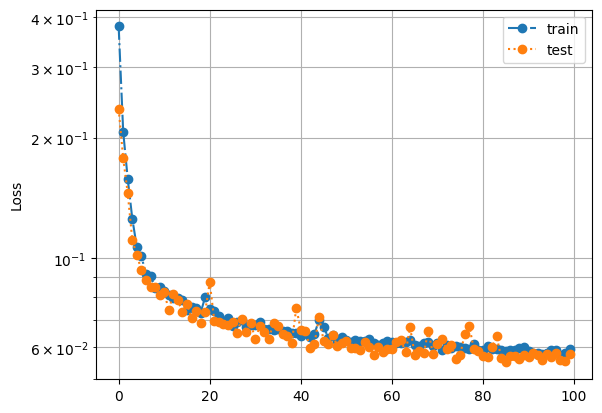

In [2]:
plt.plot(train_loss,"-.o",label="train")
plt.plot(test_loss,":o",label="test")
plt.legend()
plt.yscale("log")
plt.ylabel("Loss")
plt.grid()
plt.grid(which="minor")
plt.show()

In [7]:

import denoising_diffusion_1d
from denoising_diffusion_1d import Unet1D, GaussianDiffusion1D, extract

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

seq_length = 16384 # 8192

unet = Unet1D(
    dim = 32,
    dim_mults = (1, 2, 4, 4, 4, 4, 8),
    channels = 5,
    self_condition = args.self_cond
)

model = GaussianDiffusion1D(
    unet,
    seq_length = seq_length, 
    objective = args.objective
).to(device)


In [10]:
import glob
n_epoch = len(list(checkpoint_path.glob("*.pt")))
checkpoint = torch.load(checkpoint_path / ("%i.pt" % (n_epoch-1)))
model.load_state_dict(checkpoint['model_state_dict'])
_ = model.to(device)

In [33]:
shape = (4, model.channels, model.seq_length)
b = shape[0]
x = torch.randn(shape, device=device) 
t = model.num_timesteps - 1
batched_times = torch.full((b,), t, device = device, dtype = torch.long)
model_mean, posterior_variance, posterior_log_variance, x_start = model.p_mean_variance(x = x, t = batched_times, x_self_cond = None, clip_denoised = False)

In [34]:
preds = model.model_predictions(x, batched_times, x_self_cond = None)

OutOfMemoryError: CUDA out of memory. Tried to allocate 32.00 MiB. GPU 0 has a total capacity of 7.92 GiB of which 11.69 MiB is free. Including non-PyTorch memory, this process has 7.91 GiB memory in use. Of the allocated memory 7.60 GiB is allocated by PyTorch, and 177.90 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [44]:
alphas = 1. - model.betas
inb = x - extract(model.betas / torch.sqrt(1.-model.alphas_cumprod), batched_times, x.shape) * preds.pred_noise
m = extract(1. / alphas.sqrt(), batched_times, x.shape) * inb

In [46]:
m - model_mean

tensor([[[  15.0539,   -6.7722,  -47.4528,  ...,   71.1823,  -17.8808,
           -34.5111],
         [  13.4382,   55.4280,  -40.1331,  ...,  -20.3558,   95.6497,
            41.4615],
         [  -5.6961,   63.0501,   -9.4796,  ...,  -40.9578,  -47.7218,
            35.1199],
         [  18.3678,   22.1859,    1.9048,  ...,  -69.7974,   -8.8950,
            15.2817],
         [  10.9123,   19.9711,   39.6576,  ...,    0.9064,  -22.2494,
             7.9041]],

        [[  -2.3518,   41.7603,   -5.1495,  ...,  -25.3284,   43.1789,
           -49.7206],
         [  21.7207,  -51.2670,   44.7792,  ...,  -74.3473,   48.5209,
            25.9934],
         [ -25.4791,    9.4921,   -6.0704,  ...,  -34.5703,   48.4053,
            19.1163],
         [   9.7165,   -4.2552,   29.2050,  ...,   50.0688,   64.3979,
             7.4726],
         [   2.3111,  -34.6345,  -71.5601,  ..., -108.0338,   50.2266,
            28.8097]],

        [[  10.3284,  -21.7490,    6.9829,  ...,   10.4608,   33.2